# Customer Analysis Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

Populating the interactive namespace from numpy and matplotlib


In [2]:
#print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#display all the columns
pd.options.display.max_columns = None

## Data Preprocessing

In [3]:
df  = pd.read_csv('marketing_campaign.csv', sep='\t')

## Data Analyzation

Analyze dataset to see what needs to be dropped, binarized, and what columns have null values

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [5]:
len(df)

2240

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [8]:
for c in df.columns:
    print(c + ' ' + str(df[c].nunique()) )

ID 2240
Year_Birth 59
Education 5
Marital_Status 8
Income 1974
Kidhome 3
Teenhome 3
Dt_Customer 663
Recency 100
MntWines 776
MntFruits 158
MntMeatProducts 558
MntFishProducts 182
MntSweetProducts 177
MntGoldProds 213
NumDealsPurchases 15
NumWebPurchases 15
NumCatalogPurchases 14
NumStorePurchases 14
NumWebVisitsMonth 16
AcceptedCmp3 2
AcceptedCmp4 2
AcceptedCmp5 2
AcceptedCmp1 2
AcceptedCmp2 2
Complain 2
Z_CostContact 1
Z_Revenue 1
Response 2


In [9]:
#make a copy to clean up the data in the way we want while also keeping the original data set
df2 = df.copy()

### Data Cleaning

In [10]:
#drop the income rows that are null, as there are only 24, which represents 1% of the data
df2.dropna(how = 'any', subset =['Income'], inplace = True)

In [11]:
#drop attributes that do not provide value to the analysis
df2.drop(['ID','Dt_Customer','Z_CostContact','Z_Revenue','Complain'], axis=1,  inplace = True)

In [12]:
df2.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Response'],
      dtype='object')

In [13]:
df2.groupby('Marital_Status')['Marital_Status'].size()

Marital_Status
Absurd        2
Alone         3
Divorced    232
Married     857
Single      471
Together    573
Widow        76
YOLO          2
Name: Marital_Status, dtype: int64

In [14]:
#Yolo, Absurd, and Alone are a small section of  the marital status column.
#replace those values to Single. All categories signify Single
df2.Marital_Status.replace(['YOLO','Absurd','Alone'], value = 'Single', inplace = True)

In [15]:
df2.Marital_Status.unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow'], dtype=object)

In [16]:
#2n Cycle is another name for master's, so replace 2n cycle with master
df2.Education.replace(to_replace ='2n Cycle', value = 'Master', inplace = True)

In [17]:
df2.Education.unique()

array(['Graduation', 'PhD', 'Master', 'Basic'], dtype=object)

In [18]:
#make the categorial data into numerical data
df2 = pd.get_dummies(df2,columns=['Marital_Status','Education'])

In [19]:
df2.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Education_Basic,Education_Graduation,Education_Master,Education_PhD
0,1957,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,1954,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,1965,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,1984,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,1981,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Add columns that we will use in our findings and reorder the columns based off what we thinks makes sense. Use different ways to add the new columns and redorder the columns, depending on whihc way is the easiest to do

In [20]:
df2['TotalChildren'] = (df2.Kidhome + df2.Teenhome)

In [21]:
df2['TotalCmpAccpt'] = (df2.AcceptedCmp3+df2.AcceptedCmp4+df2.AcceptedCmp5+df2.AcceptedCmp1+\
                        df2.AcceptedCmp2+df2.Response)

In [22]:
#rename the attributes so they are more coordinated, shorter, and readable
df2.columns =['BirthYear',
            'Income',
            'Kids',
            'Teens',
            'Recency',
            'Wine',
            'Fruits',
            'Meat',
            'Fish',
            'Sweets',
            'Gold',
            'DealPurchases',
            'WebPurchases',
            'CatalogPurchases',
            'StorePurchases',
            'MonthWebVisits',
            'Campaign3',
            'Campaign4',
            'Campaign5',
            'Campaign1',
            'Campaign2',
            'Campaign6', 
            'Divorced',
            'Married',
            'Single',
            'Together',
            'Widow', 
            'Basic', 
            'Graduation', 
            'Master\'s', 
            'Phd',
            'TotalChildren',
            'TotalCmpAccpt'] 

In [23]:
list_col = df2.columns.tolist()

In [24]:
list_col

['BirthYear',
 'Income',
 'Kids',
 'Teens',
 'Recency',
 'Wine',
 'Fruits',
 'Meat',
 'Fish',
 'Sweets',
 'Gold',
 'DealPurchases',
 'WebPurchases',
 'CatalogPurchases',
 'StorePurchases',
 'MonthWebVisits',
 'Campaign3',
 'Campaign4',
 'Campaign5',
 'Campaign1',
 'Campaign2',
 'Campaign6',
 'Divorced',
 'Married',
 'Single',
 'Together',
 'Widow',
 'Basic',
 'Graduation',
 "Master's",
 'Phd',
 'TotalChildren',
 'TotalCmpAccpt']

In [25]:
#sort the campaigns so it is easier to read
list_col[list_col.index('Campaign3'):list_col.index('Campaign6')]\
                = sorted(list_col[list_col.index('Campaign3'):list_col.index('Campaign6')])

In [26]:
#order the added columns
list_col.insert(4, list_col.pop(-2))
list_col.insert(df2.columns.get_loc('Campaign6')+2, list_col.pop(-1))

In [27]:
#assign the renamed and redorded columns to the clean dataframe
df2 = df2.reindex(columns= list_col)

In [28]:
df2.head()

,BirthYear,Income,Kids,Teens,TotalChildren,Recency,Wine,Fruits,Meat,Fish,Sweets,Gold,DealPurchases,WebPurchases,CatalogPurchases,StorePurchases,MonthWebVisits,Campaign1,Campaign2,Campaign3,Campaign4,Campaign5,Campaign6,TotalCmpAccpt,Divorced,Married,Single,Together,Widow,Basic,Graduation,Master's,Phd
0,1957,58138.0,0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,1954,46344.0,1,1,2,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,1965,71613.0,0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,1984,26646.0,1,0,1,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,1981,58293.0,1,0,1,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


## Data set description

After cleaning, we have a DataFrame df2, which reports the enrolled customers of a certain company (one customer per row ). The columns are:

* **BirthYear**: Customer's year of birth
* **Income**: Customer's annual household income
* **Kids**: Number of kids in each customer's household
* **Teens**: Number of teens in each customer's household
* **TotalChildren**: Number of kids and teens in each customer's household
* **Recency**: Number of days since customer's last purchase
* **Wine, Fruits, Meat, Fish, Sweets, and Gold** : The amount the customer spent on each product in the last 2 years
* **DealPurchases**: The number of purchases customer made with a discount
* **WebPurchases**: The number of purchases customer made through the company's website
* **CatalogPurchases**: The number of purchases customer made using a catalog
* **StorePurchases**: The number of purchases customer made in the store
* **MonthWebVisits**: The number of times a customer visited the company's website in the last month
* **Campaign 1-6**: Binary attibute that indicates whether the customer accepted the offer in each campaign
* **TotalCmpAccpt**: The maximum number of accepted campaigns per customer
* **Divorced, Married, Single, Together, Widow**: Binary attibute that indicates the customer's marital status
* **Basic, Graduation, Master's, Phd**: Binary attibute that indicates the customer's highest education level 

# Interesting Finding 1:  Sweets and Children Correlation

### Is there a correlation between children and the amount of purchases of certain products?

In [29]:
corr = df2.corr()

In [30]:
corr.loc['TotalChildren'].nsmallest()

Meat               -0.504545
CatalogPurchases   -0.443474
Fish               -0.427841
Fruits             -0.395901
Sweets             -0.389411
Name: TotalChildren, dtype: float64

#### What is the count of customers with total number of children?

In [31]:
df2.groupby('TotalChildren')['TotalChildren'].size()

TotalChildren
0     633
1    1117
2     416
3      50
Name: TotalChildren, dtype: int64

In [32]:
#percent of customers that have at least one child
(df2.TotalChildren !=0).sum()/len(df2)

0.7143501805054152

## Summary of Finding:
Customers who have more children tend to buy less sweet products. 

## Graph below shows a decrease in sweets purchases as children number go up

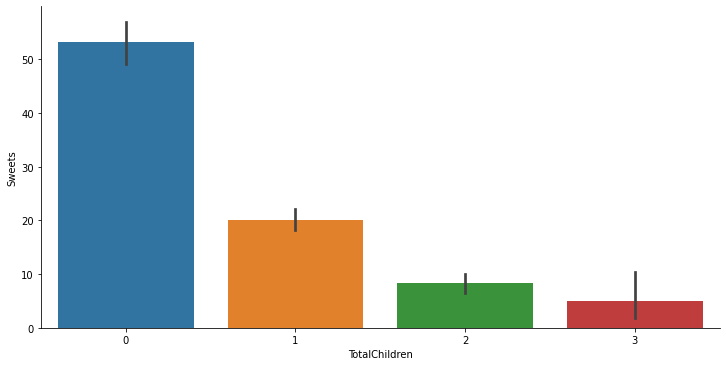

In [33]:
sns.catplot(x = 'TotalChildren',y='Sweets',kind ='bar',data=df2, aspect = 2)

## Managerial Decision
71.44% of customers have at least one child. 
To encourage these customers to buy more of sweets products, a discount on sweets can be given to these customers. 
At the same time, offering more child-oriented sweets may also increase the sale of sweets to this demographic.


# Interesting Finding 2 : Monthly Web Visits, Web Store Purchases, and Income Relation

### Lets Identify customers through Clustering

In [34]:
from sklearn.cluster import KMeans
clu = KMeans(n_clusters=2,random_state=0)
#after running the cross validation code, KMeans = 2 had one of the highest siloutte scores
#this showed the most interesting cluster

#### Using KMeans 

In [35]:
#through discovery of these columns of being highly correlated, we removed them for clustering
df_clust = df2.drop(columns =['Kids', 'Teens', 'Wine', 'Fruits', 'Meat', 'Fish', 'Sweets',\
                         'Gold','DealPurchases','CatalogPurchases', 'StorePurchases',\
                         'Campaign1', 'Campaign2', 'Campaign3','Campaign4', 'Campaign5','Campaign6'], axis =1)

In [46]:
clu.fit(df_clust)
df_clust['Clustered'] = clu.labels_

KMeans(n_clusters=2, random_state=0)

In [47]:
df_clust.groupby('Clustered').mean()

,BirthYear,Income,TotalChildren,Recency,WebPurchases,MonthWebVisits,TotalCmpAccpt,Divorced,Married,Single,Together,Widow,Basic,Graduation,Master's,Phd
Clustered,,,,,,,,,,,,,,,,
0,1970.862489,34765.867711,1.18799,49.105309,2.780679,6.647520,0.228895,0.100957,0.381201,0.233246,0.255875,0.028721,0.046997,0.493473,0.268930,0.190601
1,1966.621368,71072.096532,0.68791,48.912840,5.490159,3.888472,0.685098,0.108716,0.392690,0.196813,0.261481,0.040300,0.000000,0.514527,0.239925,0.245548


In [68]:
df_clust.groupby('Clustered')[['Income','WebPurchases','MonthWebVisits']].mean()

,Income,WebPurchases,MonthWebVisits
Clustered,,,
0,34765.867711,2.780679,6.647520
1,71072.096532,5.490159,3.888472


## Summary of Finding:

Lower income customers visit the web more every month, while customers with a higher income make more online purchases.

In [57]:
#bin values chosen based on clusters, discovery showed interesting results
df_clust['binned_income'] = pd.cut(df_clust.Income,bins=[0,34000,71000,df_clust.Income.max()])

<AxesSubplot:xlabel='binned_income'>

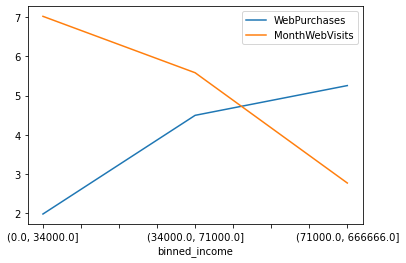

In [72]:
df_clust.groupby('binned_income')[['WebPurchases','MonthWebVisits']].mean().plot()

In [64]:
df_clust.pivot_table(index = 'binned_income',\
                     values=['WebPurchases','MonthWebVisits'])

,MonthWebVisits,WebPurchases
binned_income,,
"(0.0, 34000.0]",7.023810,1.980159
"(34000.0, 71000.0]",5.584739,4.497992
"(71000.0, 666666.0]",2.770878,5.256959


<AxesSubplot:xlabel='binned_income'>

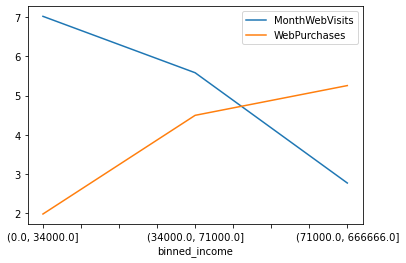

In [66]:
df_clust.pivot_table(index = 'binned_income',\
                     values=['WebPurchases','MonthWebVisits']).plot()

## Monthly Web Visits is more in case of lower income people showing a downward trend

In [ ]:
sns.catplot(y='MonthWebVisits',x ='binned_income',data=df_clust,kind='bar',aspect=3)

## Graph below shows a gradual increase in web purchases with increasing income

In [ ]:
sns.catplot(y='WebPurchases',x ='binned_income',data=df_clust,kind='bar',aspect=3)

## Managerial Decision
In order to increase the purchase rate of lower income customers, they should be targeted with online discounts after they have visited the website 3 times in one month. 

# Interesting Finding 3 : Classify who has accepted a previous campaign

### How many customers have accepted at least one offer from a campaign?

In [ ]:
#create attribute to track who has accepted a previous campaign
df2['AccptPrevCmp'] = (df2.TotalCmpAccpt > 0)*1.0
#percent of customers who have accepted a previous campaign
(df2.AccptPrevCmp.sum())/len(df2)

In [ ]:
#show new variable column
df2.head()

## Can we classify the customers who will accept at least one campaign offer?

### Use a decision tree to classify

In [ ]:
#create X by dropping columns associated with the attribute AccptPrevCmp
X = df2.drop(columns=['Campaign1','Campaign2','Campaign3','Campaign4',\
                      'Campaign5','Campaign6','AccptPrevCmp', 'TotalCmpAccpt'])
#create the Y column we're trying to predict and explain
Y = df2.AccptPrevCmp
#create and fit decision tree
dt = tree.DecisionTreeClassifier(max_depth=2) 
dt.fit(X,Y)

In [ ]:
#view decision tree
dt_feature_names = list(X.columns)
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=['0','1'],
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

## Summary of Finding:
Customers who have accepted at least one campaign tend to make more than \\$82,250 and spend more than \\$666.5 in wine.

In [ ]:
#wine was partially binned based on the decision tree.
#the other binned levels were based on discovery.
df2['binned_Wine'] = pd.cut(df2.Wine,bins=[0,500,650,800,1500], include_lowest=True)

# Income was binned based on the decision tree.
df2['binned_Income'] = pd.cut(df2.Income,bins=[0,82250,666666],include_lowest=True)

## Graph shows a gradual increase in accepting previous campaigns as income and amount of wine bought increases

In [ ]:
sns.catplot(data=df2, x='binned_Wine',y='AccptPrevCmp',hue='binned_Income',kind='point',aspect=2)

In [ ]:
df2.drop(columns=['AccptPrevCmp','binned_Wine','binned_Income'], axis =1 ,inplace = True)

## Managerial Decision
In order to reduce campaign marketing costs and increase campaign participation rate, the next campaign should be targeted at those who have income over \\$82,250 and have purchased at least \\$500 in wine.